In [38]:
import pandas as pd
import numpy as np

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima import auto_arima
from tbats import TBATS

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

# import tensorflow
import tensorflow_probability as tfp
import datetime as dt

import warnings
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv("data/app.csv", sep=";")
df = data.copy()
df["time"] = pd.to_datetime(df["time"])
df.set_index("time", inplace=True)
df = df.asfreq("H")

In [4]:
def print_metrics(y_true, y_hat):
    mae = mean_absolute_error(y_true, y_hat)
    mape = mean_absolute_percentage_error(y_true, y_hat)
    rmse = np.sqrt(mean_squared_error(y_true, y_hat))

    print(f"MAE: {mae:.2f}")
    print(f"MAPE: {mape:.2f}")
    print(f"RMSE: {rmse:.2f}")

def plot_preds_vs_true(ser, preds):
    axs = ser.plot(color='0.25',subplots=True, sharex=True)
    axs = preds.plot(color='C0',subplots=True, sharex=True, ax=axs)

In [5]:
TEST_SIZE = 48
y_true =df.iloc[-TEST_SIZE:,0]

In [7]:
model_hw = ExponentialSmoothing(
    df.iloc[:-TEST_SIZE,0],
    trend = "add",
    seasonal = "mul",
    seasonal_periods=24
).fit()

preds = model_hw.forecast(steps=TEST_SIZE).rename("HW")

print_metrics(y_true, preds)

MAE: 9.69
MAPE: 0.18
RMSE: 13.83


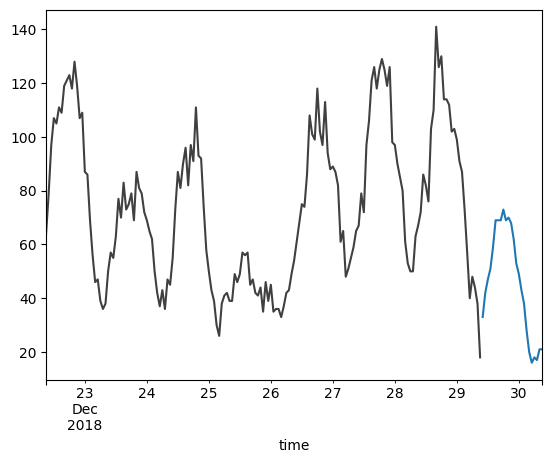

In [57]:
plot_preds_vs_true(df.loc[:,"users"], preds)

In [53]:
model_tbats = TBATS(
    seasonal_periods=[24]
)
model_tbats = model_tbats.fit(df.iloc[-120:,0])

preds_tbats = pd.DataFrame(model_tbats.forecast(steps = 24), index=df.index[-24:]+dt.timedelta(days=1))

In [10]:
print_metrics(y_true,preds_tbats)

MAE: 14.92
MAPE: 0.20
RMSE: 18.16


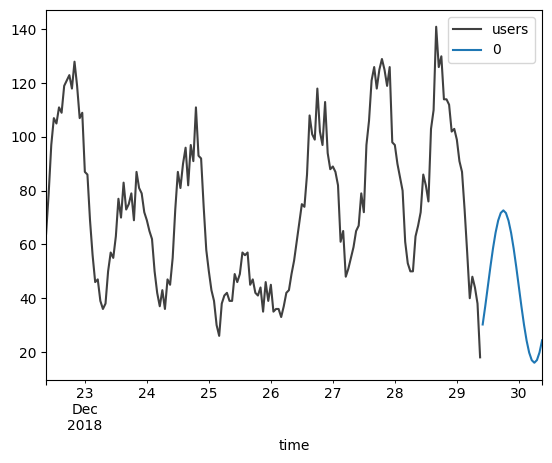

In [54]:
plot_preds_vs_true(df.iloc[:,0], preds_tbats)

In [12]:
model_arima = auto_arima(
    y = df.iloc[:-TEST_SIZE,0],
    X = df.iloc[:-TEST_SIZE,1:],
    m = 24,
    seasonal= True,
    stepwise= True,
    random_state=42
)

In [13]:
model_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  121
Model:               SARIMAX(2, 1, 0)   Log Likelihood                -382.984
Date:                Mon, 12 Dec 2022   AIC                            777.968
Time:                        21:40:46   BIC                            794.693
Sample:                    12-22-2018   HQIC                           784.760
                         - 12-27-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sessions       0.4174      0.040     10.450      0.000       0.339       0.496
newusers       0.4480      0.157      2.847      0.004       0.140       0.756
crashes       -0.3196      0.815     -0.392      0.695      -1.917       1.278
ar.L1         -0.1804      0.089     -2.026      0.043      -0.355      -0.006
ar.L2          0.2330      0.106      2.190      0.029       0.024       0.442
sigma2        34.5978      4.332      7.986      0.000      26.107      43.089
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.34
Prob(Q):                              0.88   Prob(JB):                         0.85
Heteroskedasticity (H):               0.89   Skew:                            -0.01
Prob(H) (two-sided):                  0.73   Kurtosis:                         3.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
preds_arima = pd.Series(model_arima.predict(
                        n_periods = TEST_SIZE,
                        X = df.iloc[-TEST_SIZE:,1:])).rename("SARIMAX")
                        
print_metrics(y_true, preds_arima)

MAE: 16.38
MAPE: 0.20
RMSE: 19.49


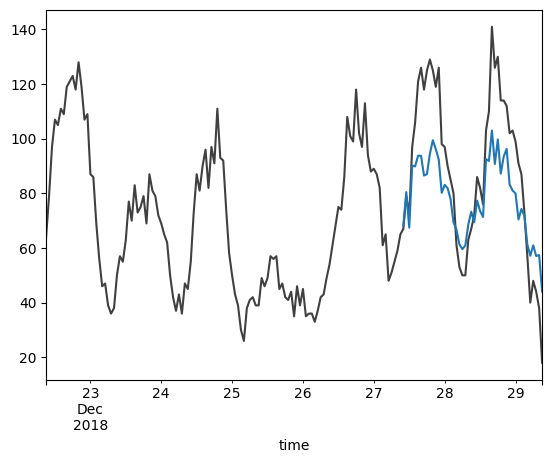

In [16]:
plot_preds_vs_true(df.iloc[:,0], preds_arima)